In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random
import csv

/home/ziyi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Network Parameters
num_input = 6
timesteps = 50 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [3]:
def read_sensor(filename):
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        dataset = [row[17:23] for row in reader]
        #data_x
        return np.array(dataset)
    
def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    #L-1 R-0
    strike_times.append([0.0, 0.5])
    for i in range(len(all_foot)):
        if(all_foot[i]=='L'):
            strike_times.append([float(all_time[i]), 1])
        else:
            strike_times.append([float(all_time[i]), 0])
    strike_times[-1][1] = 0.5
    strike_times.append([length/25.0, 0.5])

    window_y = []
    strike_index=0
    for i in range(length):
        if(i/25.0 >= strike_times[strike_index+1][0]):
            strike_index += 1
        window_y.append([strike_times[strike_index][1]])

    p_info = re.compile(r'<StartTime>(.*?)</StartTime>\n\t<EndTime>(.*?)</EndTime>\n\t<NSteps>(.*?)</NSteps>\n\t<Direction>(.*?)</Direction>')
    all_info = p_info.findall(cts)#start_time, end_time, step_num, direction=turn

    for i in range(len(all_info)):
        if(all_info[i][3][:4]=='Turn'):
#             print(all_info[i])
            start_time = int(float(all_info[i][0])*25)
            end_time = int(float(all_info[i][1])*25)
#             print('start and end time : ', all_info[i][0], all_info[i][1])
            for t in range(start_time-1, end_time):
                window_y[t] = [0.5]

    p_feature = re.compile(r'<Feature>\n\t\t\t<StartTime>(.*?)</StartTime>\n\t\t\t<EndTime>(.*?)</EndTime>')
    all_feature = p_feature.findall(cts)#start_time, end_time, step_num, direction=turn
    
#     print(filename, length)
    for i in range(len(all_feature)):
        start_time = int(float(all_feature[i][0])*25)
        end_time = int(float(all_feature[i][1])*25)
#         print(start_time-1, end_time)
        if(end_time<=length):
            for t in range(start_time-1, end_time):
                window_y[t] = [0.5]
            
#     print(len(window_y))  
    return window_y

def add_data(path, person, phone_location, assistant):
    data_x = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(path)+'_ID'+str(person)+'_'+phone_location+'_'+assistant+'.csv')
    data_y = read_xml('weallwalk/xml/T'+str(path)+'_ID'+str(person)+'_'+assistant+'.xml', len(data_x))
    
    split_x, split_x_part = [], []
    split_y, split_y_part = [], []
    for i in range(len(data_y)):
        if(data_y[i][0]!=0.5):
            split_y_part.append(data_y[i])
            split_x_part.append(data_x[i])
        else:
            if(len(split_y_part)>0):
                split_y.append(split_y_part)
                split_x.append(split_x_part)
                split_y_part = []
                split_x_part = []
    
    data_x_seq, data_y_seq = [], []
    for i in range(len(split_x)):
        data_x_part, data_y_part = [], []
        for j in range(len(split_x[i])-timesteps):
            x = split_x[i][j:j+timesteps]
            y = split_y[i][j:j+timesteps]
            data_x_part.append(x)
            data_y_part.append(y)
        if(len(data_x_part)>0):
            data_x_seq.append(data_x_part)
            data_y_seq.append(data_y_part)
    
    return data_x_seq, data_y_seq

In [4]:
step_data_list = []
for i in range(1,5):
    step_data_list.append([i, 1, '1L', 'GD'])
    step_data_list.append([i, 1, '2R', 'GD'])
    step_data_list.append([i, 4, '1L', 'GD'])
    step_data_list.append([i, 4, '2R', 'GD'])
    step_data_list.append([i, 8, '1L', 'GD'])
    step_data_list.append([i, 8, '2R', 'GD'])
    
print(step_data_list)

[[1, 1, '1L', 'GD'], [1, 1, '2R', 'GD'], [1, 4, '1L', 'GD'], [1, 4, '2R', 'GD'], [1, 8, '1L', 'GD'], [1, 8, '2R', 'GD'], [2, 1, '1L', 'GD'], [2, 1, '2R', 'GD'], [2, 4, '1L', 'GD'], [2, 4, '2R', 'GD'], [2, 8, '1L', 'GD'], [2, 8, '2R', 'GD'], [3, 1, '1L', 'GD'], [3, 1, '2R', 'GD'], [3, 4, '1L', 'GD'], [3, 4, '2R', 'GD'], [3, 8, '1L', 'GD'], [3, 8, '2R', 'GD'], [4, 1, '1L', 'GD'], [4, 1, '2R', 'GD'], [4, 4, '1L', 'GD'], [4, 4, '2R', 'GD'], [4, 8, '1L', 'GD'], [4, 8, '2R', 'GD']]


In [5]:
data_x, data_y = [], []
for i in step_data_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    for dx in data_x_segement:
        data_x.extend(dx)
    for dy in data_y_segement:
        data_y.extend(dy)
    
print(len(data_x))
print(len(data_y))

50526
50526


In [6]:
order = list(range(0,len(data_x),1))
random.shuffle(order)

train_x = [data_x[i] for i in order]
train_y = [data_y[i] for i in order]

print(len(train_x))

50526


In [7]:
step_valid_list = []   

for i in range(5,6):
    step_valid_list.append([i, 1, '1L', 'GD'])
    step_valid_list.append([i, 1, '2R', 'GD'])
    step_valid_list.append([i, 4, '1L', 'GD'])
    step_valid_list.append([i, 4, '2R', 'GD'])
    step_valid_list.append([i, 8, '1L', 'GD'])
    step_valid_list.append([i, 8, '2R', 'GD'])
      
print(step_valid_list)

[[5, 1, '1L', 'GD'], [5, 1, '2R', 'GD'], [5, 4, '1L', 'GD'], [5, 4, '2R', 'GD'], [5, 8, '1L', 'GD'], [5, 8, '2R', 'GD']]


In [8]:
valid_x, valid_y=[], []
for i in step_valid_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    valid_x.extend(data_x_segement)
    valid_y.extend(data_y_segement)
#     test_x.append(data_x_segement)
#     test_y.append(data_y_segement)
    
print(len(valid_x))
print(len(valid_y))

print([len(i) for i in valid_y])

44
44
[16, 444, 678, 327, 412, 304, 1500, 16, 444, 678, 327, 412, 304, 1500, 16, 320, 389, 62, 217, 284, 124, 1055, 16, 320, 389, 62, 217, 284, 124, 1055, 14, 354, 571, 266, 339, 265, 970, 14, 354, 571, 266, 339, 265, 970]


In [9]:
step_test_list = []   

for i in range(6,7):
    step_test_list.append([i, 1, '1L', 'GD'])
    step_test_list.append([i, 1, '2R', 'GD'])
    step_test_list.append([i, 4, '1L', 'GD'])
    step_test_list.append([i, 4, '2R', 'GD'])
    step_test_list.append([i, 8, '1L', 'GD'])
    step_test_list.append([i, 8, '2R', 'GD'])
      
print(step_test_list)

[[6, 1, '1L', 'GD'], [6, 1, '2R', 'GD'], [6, 4, '1L', 'GD'], [6, 4, '2R', 'GD'], [6, 8, '1L', 'GD'], [6, 8, '2R', 'GD']]


In [10]:
test_x, test_y=[], []
for i in step_test_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    test_x.extend(data_x_segement)
    test_y.extend(data_y_segement)
#     test_x.append(data_x_segement)
#     test_y.append(data_y_segement)
    
print(len(test_x))
print(len(test_y))

print([len(i) for i in test_y])

20
20
[217, 204, 1235, 83, 217, 204, 1235, 83, 448, 810, 20, 448, 810, 20, 481, 949, 15, 481, 949, 15]


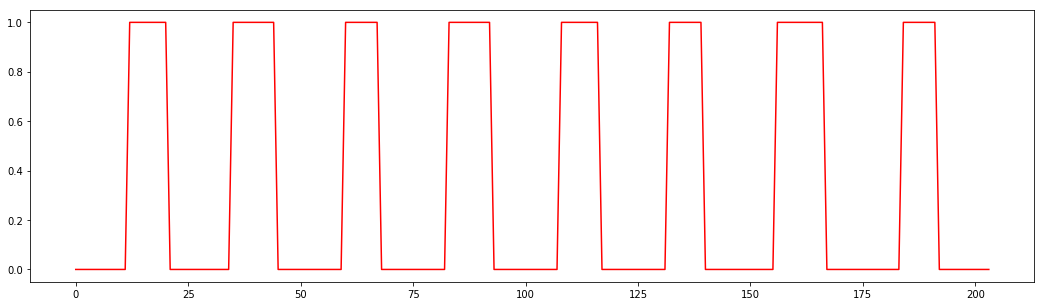

In [11]:
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in test_y[1]], 'r')
plt.show()

In [12]:
NUM_LAYERS=2

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden)#, forget_bias=1.0)
    cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=0.5)
    return cell

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, timesteps, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

#         return tf.matmul(outputs[-2], weights['out']) + biases['out']
        ret = []
#         print(outputs.shape)
        for i in range(0, timesteps):
            ret.append(tf.matmul(outputs[i], weights['out']) + biases['out'])
            
        return ret

#         return np.array(ret)
    
    logits = RNN(X, weights, biases)
    logits = tf.transpose(logits, [1,0,2])
#     print(len(logits))
    print(logits.shape)
    print(logits[0].shape)
    mean_train = tf.reduce_mean(X)
    
    
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    
    saver = tf.train.Saver()

(?, 50, 1)
(50, 1)


In [13]:
batch_size = 256
batch_start = 0;
train_length = len(train_x)
print(train_length)

train_x_extend = [i for i in train_x]
train_y_extend = [i for i in train_y]

print(len(train_x_extend))

50526
50526


In [14]:
if(len(train_x_extend)==len(train_x)):
    train_x_extend.extend(train_x[0:batch_size])
    train_y_extend.extend(train_y[0:batch_size])
print(len(train_x_extend))

50782


In [15]:
def cal_accuarcy(y, _y):
#     print(len(y))
#     print(len(y[0]))
#     print(len(y[0][0]))
#     print(y[0][0])
    count = 0
    total = 0
    for i in range(len(y[0])):
        total += 1
        if(y[0][i][0] == round(_y[0][i][0])):
            count += 1
    for i in range(1, len(y)):
        total += 1
        if(y[i][-1][0] == round(_y[i][-1][0])):
            count += 1;
    return(count*1.0/total)
#     print("train accuarcy : ", count/len(y))

In [30]:
training_steps = 3001

config = tf.ConfigProto(allow_soft_placement=True)
# config.gpu_options.allocator_type = 'BFC'
# config.gpu_options.per_process_gpu_memory_fraction = 0.40
with tf.Session(graph=graph, config=config) as session:
#     saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
#     saver.restore(session, "lstm_check/my-model-gpu-error-metric-dropout2-gd.ckpt-5000")
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(training_steps):      
        feed_dict = {X: train_x[batch_start:batch_start+batch_size], Y: train_y[batch_start:batch_start+batch_size]}
        _, l, predictions, m = session.run([optimizer, loss, logits, mean_train], feed_dict = feed_dict)
        if (step % 200 == 0):
            train_accuarcy = cal_accuarcy(train_y[batch_start:batch_start+batch_size], predictions)
            print('Loss at step %d: %f, train accuarcy : %f' % (step, l, train_accuarcy))
            #train accuarcy
        if (step % 1000 == 0):
            saver.save(session, 'lstm_check/my-model-gpu-error-metric-dropout2-gd.ckpt', global_step=step)
        batch_start += batch_size
        if(batch_start>=train_length):
            batch_start -=train_length
#     train_loss, train_logits = session.run([loss,logits], feed_dict={X: train_x, Y: train_y})
#     test_loss, test_logits = session.run([loss,logits], feed_dict={X: test_x, Y: test_y})
    test_loss, test_logits = [], []
    for i in range(len(test_x)):
#         saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
        test_loss_part, test_logits_part = session.run([loss,logits], feed_dict={X: test_x[i], Y: test_y[i]})
        test_loss.append(test_loss_part)
        test_logits.append(test_logits_part)
        
    valid_loss, valid_logits = [], []
    for i in range(len(valid_x)):
#         saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
        valid_loss_part, valid_logits_part = session.run([loss,logits], feed_dict={X: valid_x[i], Y: valid_y[i]})
        valid_loss.append(valid_loss_part)
        valid_logits.append(valid_logits_part)

Initialized
Loss at step 0: 0.429875, train accuarcy : 0.449180
Loss at step 200: 0.120769, train accuarcy : 0.875410
Loss at step 400: 0.100113, train accuarcy : 0.911475
Loss at step 600: 0.079659, train accuarcy : 0.901639
Loss at step 800: 0.073024, train accuarcy : 0.911475
Loss at step 1000: 0.067183, train accuarcy : 0.918033
Loss at step 1200: 0.068893, train accuarcy : 0.931148
Loss at step 1400: 0.065733, train accuarcy : 0.950820
Loss at step 1600: 0.059491, train accuarcy : 0.954098
Loss at step 1800: 0.064077, train accuarcy : 0.940984
Loss at step 2000: 0.059863, train accuarcy : 0.944262
Loss at step 2200: 0.060927, train accuarcy : 0.944262
Loss at step 2400: 0.053983, train accuarcy : 0.944262
Loss at step 2600: 0.054054, train accuarcy : 0.954098
Loss at step 2800: 0.050286, train accuarcy : 0.973770
Loss at step 3000: 0.056035, train accuarcy : 0.957377


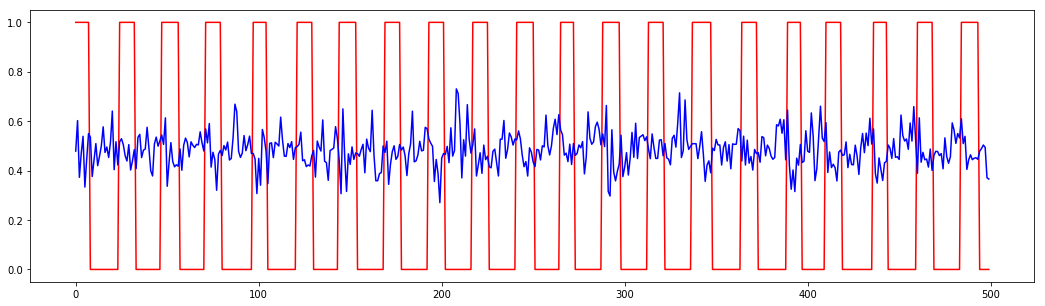

In [31]:
plt.figure(figsize=(18, 5))
index=2
start=0
end=500
plt.plot([i[0] for i in test_y[index][start:end]], 'r')
plt.plot([i[0] for i in test_logits[index][start:end]], 'b')
plt.show()

In [32]:
print("test loss : ", test_loss)
print(len(test_loss))

test loss :  [0.53710496, 0.49201339, 0.48864323, 0.50488245, 0.12102283, 0.10364111, 0.14515381, 0.15539099, 0.069909267, 0.059540894, 0.078309357, 0.060364924, 0.054533385, 0.15362091, 0.091440327, 0.094737224, 0.066873126, 0.082732052, 0.087513648, 0.069516987]
20


In [33]:
print(len(test_logits))
print(len(test_logits[0]))
print(len(test_logits[0][0]))  

test_y_seq_list, test_logits_bin_list = [], []

for t in test_logits:  
    t_all = [i for i in t[0]]
    t_all.extend([i[-1] for i in t[1:]])
#     print(len(t_all)-len(t))
    
    test_logits_part = [[round(i[0])] for i in t_all]
    for i in range(1, len(test_logits_part)-1):
        if(test_logits_part[i-1][0]!=test_logits_part[i][0] and test_logits_part[i-1][0]==test_logits_part[i+1][0]):
            test_logits_part[i][0]=test_logits_part[i-1][0]   
    test_logits_bin_list.append(test_logits_part)
    
    
#     test_logits_part_one = [i[0] for i in test_logits_part]
#     test_logits_part_time = [i for i in range(1, len(test_logits_part)) if test_logits_part[i-1]!=test_logits_part[i]]
#     print(test_logits_part_one)
#     print(test_logits_part_time)
#     average_time = (test_logits_part_time[-1]-test_logits_part_time[0])/(len(test_logits_part_time)-1)
#     print(average_time)
    
#     test_logits_part_one_remove = []
    
#     for i in range(1, len(test_logits_part_time)):
#         if(test_logits_part_time[i]-test_logits_part_time[i-1]<average_time/2):
#             for j in range(test_logits_part_time[i], test_logits_part_time[i-1]):
#                 test_logits_part_one[j]=
        
    
#     test_logits_bin_list.append([[i] for i in test_logits_part_one])
    
for t in test_y:  
    t_all = [i for i in t[0]]
    t_all.extend([i[-1] for i in t[1:]])
    test_y_seq_list.append(t_all)

# print(test_y_seq_list)
    
count = 0
total = 0
for i in range(0, len(test_y_seq_list)):
    total += len(test_y_seq_list[i])
    for j in range(0, len(test_y_seq_list[i])):
        if(test_y_seq_list[i][j][0] == test_logits_bin_list[i][j][0]):
            count += 1

print(count)
print(total)
print("test accuarcy : ", count*1.0/total)

20
217
50
7681
9904
test accuarcy :  0.7755452342487884


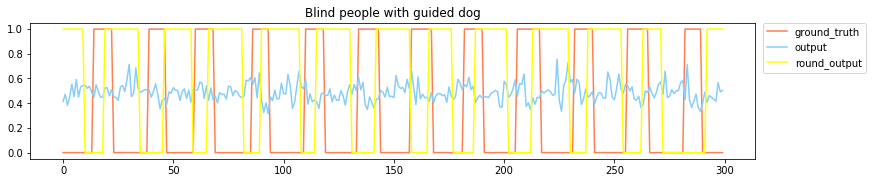

In [34]:
plt.figure(figsize=(13, 2.5))
ii=2
start=300
end=600
plt.title('Blind people with guided dog')
plt.plot([i[0] for i in test_y_seq_list[ii][start+timesteps:end+timesteps]], 'coral', label='ground_truth')
plt.plot([i[0] for i in test_logits[ii][start:end]], 'lightskyblue', label='output')
plt.plot([i[0] for i in test_logits_bin_list[ii][start+timesteps:end+timesteps]], 'yellow', label='round_output')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

In [35]:
step_time_actual, step_time_predict= [], []
step_time_actual_gap = []

#test_y_seq_list, test_logits_bin_list
for i in range(0, len(test_y_seq_list)):
    step_time_actual_part, step_time_predict_part= [], []
    for j in range(1, len(test_y_seq_list[i])):
        if(abs(test_y_seq_list[i][j][0]-test_y_seq_list[i][j-1][0])>0.5):
            step_time_actual_part.append(j)
    #     if(abs(test_logits[i][0]-test_logits[i-1][0])>0.5):
        if(abs(test_logits_bin_list[i][j][0]-test_logits_bin_list[i][j-1][0])>0.5):
            step_time_predict_part.append(j)
    step_time_actual.append(step_time_actual_part)
    
    average_time = (step_time_predict_part[-1]-step_time_predict_part[0])/(len(step_time_predict_part)-1)
    step_time_predict_part_1 = [step_time_predict_part[0]]
#     for i in range(1, len(step_time_predict_part)):
#         if(step_time_predict_part[i]-step_time_predict_part_1[-1]>average_time/2):
#             step_time_predict_part_1.append(step_time_predict_part[i])
    j = 1
    while j<len(step_time_predict_part):
        if(step_time_predict_part[j]-step_time_predict_part_1[-1]>average_time/4):
            step_time_predict_part_1.append(step_time_predict_part[j])
            j += 1
        else:
            j += 2
            
#     print(step_time_predict_part)
#     print(step_time_predict_part_1) 
    
    step_time_predict.append(step_time_predict_part_1)
    
    step_time_actual_gap_part = []
    step_time_actual_gap_part.append(0)
#     step_time_actual_gap_part.append(step_time_actual_part[0]/2.0)
    for i in range(1, len(step_time_actual_part)):
        step_time_actual_gap_part.append((step_time_actual_part[i-1]+step_time_actual_part[i])/2.0)
    step_time_actual_gap_part.append(step_time_actual_part[-1]*2)
    step_time_actual_gap.append(step_time_actual_gap_part)

print('Step number for each segement')
print([len(i) for i in step_time_actual])   
print([len(i) for i in step_time_predict])

print('======')
iii = 13
# print(step_time_actual[iii])
# print(step_time_actual_gap[iii])
# print(step_time_predict[iii])

Step number for each segement
[22, 20, 105, 10, 22, 20, 105, 10, 44, 76, 5, 44, 76, 5, 42, 78, 4, 42, 78, 4]
[26, 26, 113, 12, 21, 21, 95, 10, 44, 77, 5, 44, 75, 5, 42, 78, 4, 42, 78, 5]


In [36]:
total_step_count = sum([len(i) for i in step_time_actual])
metric1_undercount = 0
metric2_undercount = 0
metric3_undercount = 0
metric1_overcount = 0
metric2_overcount = 0
metric3_overcount = 0

metric2_overcount_list = []
metric3_overcount_list = []

print(len(test_x))

for i in range(len(test_x)):
    step_count = len(step_time_actual[i])
    undercount = 0
    overcount = 0

    for j in range(1, step_count):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][j-1] and t<step_time_actual[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += len(gap_count)-1
        if(len(gap_count)<1):
            undercount += 1
    gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][-1]]
    if(len(gap_count)>1):
        overcount += len(gap_count)-1
    if(len(gap_count)<1):
        undercount += 1
    
    metric1_undercount += undercount
    metric1_overcount += overcount
    
    undercount = 0
    overcount = 0
    for j in range(1, len(step_time_actual_gap[i])):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual_gap[i][j-1] and t<step_time_actual_gap[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += (len(gap_count)-1)
        if(len(gap_count)<1):
            undercount += 1    
    
    metric2_undercount += undercount
    metric2_overcount += overcount  
    metric2_overcount_list.append(overcount)
    
#     print(undercount, overcount)
#     print('undercount : ', undercount*1.0/step_count)
#     print('overcount : ', overcount*1.0/step_count)
    diff = len(step_time_predict[i])-len(step_time_actual[i])
#     if(diff==0):
#         print("segement correct!")

    if(diff<0):
#         print('segement undercount : ', 1-len(step_time_predict[i])*1.0/len(step_time_actual[i]))
        metric3_undercount -= diff
        metric3_overcount_list.append(0)
#     if(diff>=0):
    else:
#         print('segement overcount : ', 1-len(step_time_actual[i])*1.0/len(step_time_predict[i]))
        metric3_overcount += diff
        metric3_overcount_list.append(diff)

print(len(metric2_overcount_list))
print(sum(metric2_overcount_list))
print(metric2_overcount_list)
print(len(metric3_overcount_list))
print(sum(metric3_overcount_list))
print(metric3_overcount_list)
        
print('error : ')
print("total undercount metric 1:\t", metric1_undercount*1.0/total_step_count)
print("total overcount metric 1:\t", metric1_overcount*1.0/total_step_count)
print("total undercount metric 2:\t", metric2_undercount*1.0/total_step_count)
print("total overcount metric 2:\t", metric2_overcount*1.0/total_step_count)
print("total undercount metric 3:\t", metric3_undercount*1.0/total_step_count)
print("total overcount metric 3:\t", metric3_overcount*1.0/total_step_count)

20
20
49
[5, 8, 17, 2, 1, 1, 6, 1, 1, 1, 0, 0, 3, 1, 0, 0, 0, 1, 0, 1]
20
23
[4, 6, 8, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
error : 
total undercount metric 1:	 0.1416256157635468
total overcount metric 1:	 0.13916256157635468
total undercount metric 2:	 0.046798029556650245
total overcount metric 2:	 0.0603448275862069
total undercount metric 3:	 0.014778325123152709
total overcount metric 3:	 0.02832512315270936


# xxx

In [37]:
print(len(valid_logits))
print(len(valid_logits[0]))
print(len(valid_logits[0][0]))  

valid_y_seq_list, valid_logits_bin_list = [], []

for t in valid_logits:  
    t_all = [i for i in t[0]]
    t_all.extend([i[-1] for i in t[1:]])
#     print(len(t_all)-len(t))
    
    valid_logits_part = [[round(i[0])] for i in t_all]
    for i in range(1, len(valid_logits_part)-1):
        if(valid_logits_part[i-1][0]!=valid_logits_part[i][0] and valid_logits_part[i-1][0]==valid_logits_part[i+1][0]):
            valid_logits_part[i][0]=valid_logits_part[i-1][0]   
    valid_logits_bin_list.append(valid_logits_part)

    
for t in valid_y:  
    t_all = [i for i in t[0]]
    t_all.extend([i[-1] for i in t[1:]])
    valid_y_seq_list.append(t_all)

# print(valid_y_seq_list)
    
count = 0
total = 0
# print(len(valid_y_seq_list), len(valid_y), len(valid_logits_bin_list), len(valid_logits))
for i in range(0, len(valid_y_seq_list)):
    total += len(valid_y_seq_list[i])
#     print(len(valid_y_seq_list[i]), len(valid_logits_bin_list[i]))
    for j in range(0, len(valid_y_seq_list[i])):
        if(valid_y_seq_list[i][j][0] == valid_logits_bin_list[i][j][0]):
            count += 1

print(count)
print(total)
print("valid accuarcy : ", count*1.0/total)

44
16
50
14864
20010
valid accuarcy :  0.7428285857071464


In [38]:
step_time_actual, step_time_predict= [], []
step_time_actual_gap = []

#valid_y_seq_list, valid_logits_bin_list
for i in range(0, len(valid_y_seq_list)):
    step_time_actual_part, step_time_predict_part= [], []
    for j in range(1, len(valid_y_seq_list[i])):
        if(abs(valid_y_seq_list[i][j][0]-valid_y_seq_list[i][j-1][0])>0.5):
            step_time_actual_part.append(j)
    #     if(abs(valid_logits[i][0]-valid_logits[i-1][0])>0.5):
        if(abs(valid_logits_bin_list[i][j][0]-valid_logits_bin_list[i][j-1][0])>0.5):
            step_time_predict_part.append(j)
    step_time_actual.append(step_time_actual_part)
    
    average_time = (step_time_predict_part[-1]-step_time_predict_part[0])/(len(step_time_predict_part)-1)
    step_time_predict_part_1 = [step_time_predict_part[0]]
#     for i in range(1, len(step_time_predict_part)):
#         if(step_time_predict_part[i]-step_time_predict_part_1[-1]>average_time/2):
#             step_time_predict_part_1.append(step_time_predict_part[i])
    j = 1
    while j<len(step_time_predict_part):
        if(step_time_predict_part[j]-step_time_predict_part_1[-1]>average_time/4):
            step_time_predict_part_1.append(step_time_predict_part[j])
            j += 1
        else:
            j += 2
            
#     print(step_time_predict_part)
#     print(step_time_predict_part_1) 
    
    step_time_predict.append(step_time_predict_part_1)
    
    step_time_actual_gap_part = []
    step_time_actual_gap_part.append(0)
#     step_time_actual_gap_part.append(step_time_actual_part[0]/2.0)
    for i in range(1, len(step_time_actual_part)):
        step_time_actual_gap_part.append((step_time_actual_part[i-1]+step_time_actual_part[i])/2.0)
    step_time_actual_gap_part.append(step_time_actual_part[-1]*2)
    step_time_actual_gap.append(step_time_actual_gap_part)

print('Step number for each segement')
print([len(i) for i in step_time_actual])   
print([len(i) for i in step_time_predict])

print('======')
iii = 13
# print(step_time_actual[iii])
# print(step_time_actual_gap[iii])
# print(step_time_predict[iii])

Step number for each segement
[4, 41, 61, 31, 39, 30, 125, 4, 41, 61, 31, 39, 30, 125, 4, 30, 36, 9, 18, 29, 16, 91, 4, 30, 36, 9, 18, 29, 16, 91, 5, 32, 49, 24, 30, 24, 78, 5, 32, 49, 24, 30, 24, 78]
[5, 34, 67, 26, 39, 32, 131, 8, 40, 62, 30, 40, 31, 113, 7, 31, 37, 10, 22, 28, 16, 93, 5, 31, 36, 10, 20, 28, 16, 95, 4, 32, 48, 23, 30, 24, 79, 4, 32, 49, 23, 30, 24, 78]


In [39]:
total_step_count = sum([len(i) for i in step_time_actual])
metric1_undercount = 0
metric2_undercount = 0
metric3_undercount = 0
metric1_overcount = 0
metric2_overcount = 0
metric3_overcount = 0

metric2_overcount_list = []
metric3_overcount_list = []

print(len(valid_x))

for i in range(len(valid_x)):
    step_count = len(step_time_actual[i])
    undercount = 0
    overcount = 0

    for j in range(1, step_count):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][j-1] and t<step_time_actual[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += len(gap_count)-1
        if(len(gap_count)<1):
            undercount += 1
    gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][-1]]
    if(len(gap_count)>1):
        overcount += len(gap_count)-1
    if(len(gap_count)<1):
        undercount += 1
    
    metric1_undercount += undercount
    metric1_overcount += overcount
    
    undercount = 0
    overcount = 0
    for j in range(1, len(step_time_actual_gap[i])):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual_gap[i][j-1] and t<step_time_actual_gap[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += (len(gap_count)-1)
        if(len(gap_count)<1):
            undercount += 1    
    
    metric2_undercount += undercount
    metric2_overcount += overcount  
    metric2_overcount_list.append(overcount)
    
#     print(undercount, overcount)
#     print('undercount : ', undercount*1.0/step_count)
#     print('overcount : ', overcount*1.0/step_count)
    diff = len(step_time_predict[i])-len(step_time_actual[i])
#     if(diff==0):
#         print("segement correct!")

    if(diff<0):
#         print('segement undercount : ', 1-len(step_time_predict[i])*1.0/len(step_time_actual[i]))
        metric3_undercount -= diff
        metric3_overcount_list.append(0)
#     if(diff>=0):
    else:
#         print('segement overcount : ', 1-len(step_time_actual[i])*1.0/len(step_time_predict[i]))
        metric3_overcount += diff
        metric3_overcount_list.append(diff)

print(len(metric2_overcount_list))
print(sum(metric2_overcount_list))
print(metric2_overcount_list)
print(len(metric3_overcount_list))
print(sum(metric3_overcount_list))
print(metric3_overcount_list)
        
print('error : ')
print("total undercount metric 1:\t", metric1_undercount*1.0/total_step_count)
print("total overcount metric 1:\t", metric1_overcount*1.0/total_step_count)
print("total undercount metric 2:\t", metric2_undercount*1.0/total_step_count)
print("total overcount metric 2:\t", metric2_overcount*1.0/total_step_count)
print("total undercount metric 3:\t", metric3_undercount*1.0/total_step_count)
print("total overcount metric 3:\t", metric3_overcount*1.0/total_step_count)

44
44
97
[1, 0, 7, 0, 2, 2, 24, 4, 4, 11, 3, 6, 4, 3, 3, 2, 1, 1, 4, 0, 0, 3, 1, 2, 0, 1, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]
44
44
[1, 0, 6, 0, 0, 2, 6, 4, 0, 1, 0, 1, 1, 0, 3, 1, 1, 1, 4, 0, 0, 2, 1, 1, 0, 1, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
error : 
total undercount metric 1:	 0.2512406947890819
total overcount metric 1:	 0.23014888337468983
total undercount metric 2:	 0.05334987593052109
total overcount metric 2:	 0.06017369727047146
total undercount metric 3:	 0.020471464019851116
total overcount metric 3:	 0.02729528535980149
